<a href="https://colab.research.google.com/github/berberberk/timl-ss-2025/blob/main/TIML1_FCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![img](https://preview.redd.it/n9fgba8b0qr01.png?width=640&crop=smart&auto=webp&s=322824804404095b200c034aff2f233094e176b7)

# Импорт библиотек

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)

Используемое устройство: cpu


# Подготовка классов и функций

In [ ]:
class FCNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation='relu', dropout_prob=0.0):
        """
        input_dim: размер входного вектора (например, 784)
        hidden_dims: список с количеством нейронов в каждом скрытом слое
        output_dim: число классов (например, 10)
        activation: тип функции активации ('relu', 'sigmoid', 'tanh')
        dropout_prob: вероятность зануления нейронов (0.0 = не используется)
        """
        super(FCNN, self).__init__()
        layers = []
        last_dim = input_dim

        # Добавляем скрытые слои
        for h_dim in hidden_dims:
            layers.append(nn.Linear(last_dim, h_dim))
            if activation.lower() == 'relu':
                layers.append(nn.ReLU())
            elif activation.lower() == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation.lower() == 'tanh':
                layers.append(nn.Tanh())
            else:
                raise ValueError("Не поддерживается функция активации {}".format(activation))
            if dropout_prob > 0.0:
                layers.append(nn.Dropout(dropout_prob))
            last_dim = h_dim

        # Выходной слой (без softmax – CrossEntropyLoss работает с логитами)
        layers.append(nn.Linear(last_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [ ]:
def train_one_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in data_loader:
        # Преобразуем изображения в векторы
        inputs = inputs.view(inputs.size(0), -1).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        # Вычисляем количество верных ответов
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, data_loader, criterion, device, return_preds=False):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.view(inputs.size(0), -1).to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if return_preds:
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    if return_preds:
        return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels)
    else:
        return epoch_loss, epoch_acc

In [ ]:

def plot_metrics(train_metrics, test_metrics, ylabel, title):
    epochs = range(1, len(train_metrics)+1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_metrics, 'bo-', label='Обучение')
    plt.plot(epochs, test_metrics, 'mo-', label='Тест')
    plt.title(title)
    plt.xlabel("Эпоха")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

def plot_misclassified(model, data_loader, device, num_images=12):
    model.eval()
    misclassified_imgs = []
    misclassified_preds = []
    misclassified_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs_flat = inputs.view(inputs.size(0), -1).to(device)
            outputs = model(inputs_flat)
            _, predicted = torch.max(outputs, 1)
            # Найдём неверно классифицированные примеры
            for img, pred, true in zip(inputs.cpu(), predicted.cpu(), labels):
                if pred != true:
                    misclassified_imgs.append(img.squeeze())
                    misclassified_preds.append(pred.item())
                    misclassified_labels.append(true.item())
                if len(misclassified_imgs) >= num_images:
                    break
            if len(misclassified_imgs) >= num_images:
                break

    if misclassified_imgs:
        plt.figure(figsize=(10, 4))
        for i, (img, pred, true) in enumerate(zip(misclassified_imgs, misclassified_preds, misclassified_labels)):
            plt.subplot(3, num_images//3, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(f"Прогноз: {pred}\nКласс: {true}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Нет неверно классифицированных изображений для отображения.")


# Работа с MNIST

![img](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/MNIST_dataset_example.png/640px-MNIST_dataset_example.png)

In [ ]:
# Определяем преобразования: преобразование в тензор и нормализация
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [ ]:
# Загрузка датасета MNIST
train_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader_mnist = torch.utils.data.DataLoader(train_dataset_mnist, batch_size=batch_size, shuffle=True)
test_loader_mnist = torch.utils.data.DataLoader(test_dataset_mnist, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 49.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.66MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 12.3MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.81MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Создаем модель для MNIST: два скрытых слоя (128 и 64 нейрона), функция активации ReLU, без Dropout
model_mnist = FCNN(input_dim=28*28, hidden_dims=[128, 64], output_dim=10, activation='relu', dropout_prob=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mnist.parameters(), lr=learning_rate)

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

In [ ]:
print("Обучение на MNIST...")
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model_mnist, train_loader_mnist, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model_mnist, test_loader_mnist, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    print(f"Эпоха {epoch+1}/{num_epochs}: Train loss={train_loss:.4f}, Train acc={train_acc:.4f} | Test loss={test_loss:.4f}, Test acc={test_acc:.4f}")

Обучение на MNIST...
Эпоха 1/10: Train loss=0.3953, Train acc=0.8824 | Test loss=0.2186, Test acc=0.9313
Эпоха 2/10: Train loss=0.1937, Train acc=0.9428 | Test loss=0.1526, Test acc=0.9529
Эпоха 3/10: Train loss=0.1390, Train acc=0.9581 | Test loss=0.1403, Test acc=0.9597
Эпоха 4/10: Train loss=0.1132, Train acc=0.9657 | Test loss=0.1104, Test acc=0.9653
Эпоха 5/10: Train loss=0.0963, Train acc=0.9703 | Test loss=0.1109, Test acc=0.9643
Эпоха 6/10: Train loss=0.0852, Train acc=0.9739 | Test loss=0.0998, Test acc=0.9699
Эпоха 7/10: Train loss=0.0738, Train acc=0.9766 | Test loss=0.0908, Test acc=0.9718
Эпоха 8/10: Train loss=0.0689, Train acc=0.9786 | Test loss=0.0907, Test acc=0.9727
Эпоха 9/10: Train loss=0.0615, Train acc=0.9795 | Test loss=0.0840, Test acc=0.9759
Эпоха 10/10: Train loss=0.0547, Train acc=0.9820 | Test loss=0.1021, Test acc=0.9720


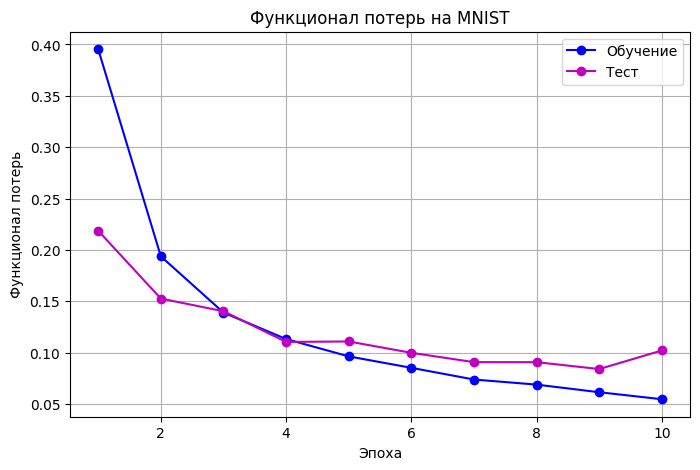

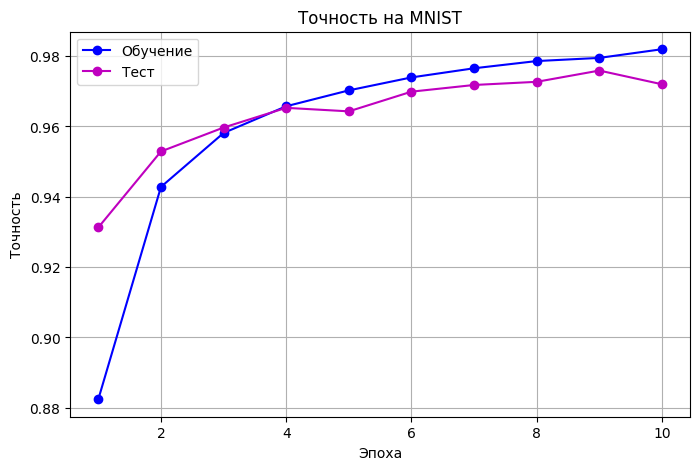

In [ ]:
# Графики для MNIST
plot_metrics(train_losses, test_losses, ylabel="Функционал потерь", title="Функционал потерь на MNIST")
plot_metrics(train_accuracies, test_accuracies, ylabel="Точность", title="Точность на MNIST")

Визуализация ошибок на MNIST:


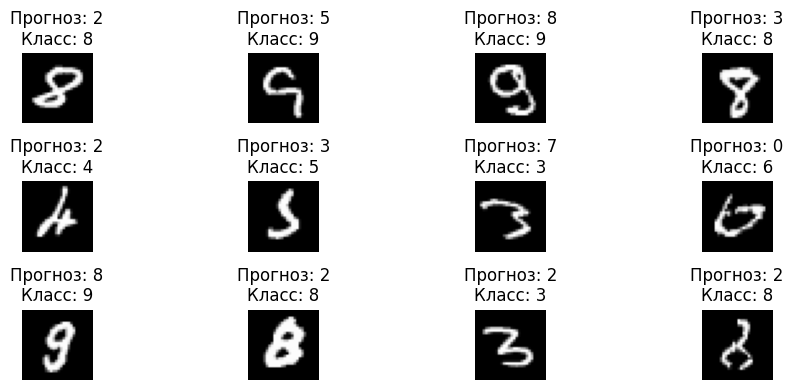

In [ ]:
# Визуализация неверно классифицированных изображений
print("Визуализация ошибок на MNIST:")
plot_misclassified(model_mnist, test_loader_mnist, device, num_images=12)

# Работа с KMNIST

![img](https://codh.rois.ac.jp/img/kmnist.png)

In [ ]:
num_epochs = 50
batch_size = 64
learning_rate = 0.001

In [ ]:
# Загрузка датасета KMNIST
train_dataset_kmnist = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_kmnist = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

train_loader_kmnist = torch.utils.data.DataLoader(train_dataset_kmnist, batch_size=batch_size, shuffle=True)
test_loader_kmnist = torch.utils.data.DataLoader(test_dataset_kmnist, batch_size=batch_size, shuffle=False)

100%|██████████| 18.2M/18.2M [00:21<00:00, 843kB/s]


Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 180kB/s]


Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 3.04M/3.04M [00:03<00:00, 839kB/s]


Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 5.12k/5.12k [00:00<00:00, 8.47MB/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



In [ ]:
# Определим два эксперимента: с dropout и без dropout.
experiments = [
    {"name": "Без Dropout, ReLU, hidden=[256, 128]", "hidden_dims": [256, 128], "activation": "relu", "dropout": 0.0},
    {"name": "С Dropout(0.5), ReLU, hidden=[256, 128]", "hidden_dims": [256, 128], "activation": "relu", "dropout": 0.5},
    # Эксперименты с другими функциями активации
    {"name": "Без Dropout, Sigmoid, hidden=[256, 128]", "hidden_dims": [256, 128], "activation": "sigmoid", "dropout": 0.0},
    {"name": "Без Dropout, Tanh, hidden=[256, 128]", "hidden_dims": [256, 128], "activation": "tanh", "dropout": 0.0},
    # Эксперименты с другим количеством нейронов в слоях
    {"name": "Без Dropout, ReLU, hidden=[512, 256]", "hidden_dims": [512, 256], "activation": "relu", "dropout": 0.0},
    {"name": "Без Dropout, ReLU, hidden=[128, 64]", "hidden_dims": [128, 64], "activation": "relu", "dropout": 0.0},
    {"name": "Без Dropout, ReLU, hidden=[256, 128, 64]", "hidden_dims": [256, 128, 64], "activation": "relu", "dropout": 0.0},
    {"name": "Без Dropout, ReLU, hidden=[512, 256, 128]", "hidden_dims": [512, 256, 128], "activation": "relu", "dropout": 0.0},
    {"name": "С Dropout(0.5), ReLU, hidden=[512, 256, 128]", "hidden_dims": [512, 256, 128], "activation": "relu", "dropout": 0.5},
]


--- Эксперимент: Без Dropout, ReLU, hidden=[256, 128] ---
Эпоха 1/50: Train loss=0.4478, Train acc=0.8601 | Test loss=0.5658, Test acc=0.8278
Эпоха 2/50: Train loss=0.2130, Train acc=0.9350 | Test loss=0.4970, Test acc=0.8457
Эпоха 3/50: Train loss=0.1526, Train acc=0.9523 | Test loss=0.3945, Test acc=0.8873
Эпоха 4/50: Train loss=0.1166, Train acc=0.9631 | Test loss=0.4239, Test acc=0.8830
Эпоха 5/50: Train loss=0.0940, Train acc=0.9697 | Test loss=0.4207, Test acc=0.8831
Эпоха 6/50: Train loss=0.0768, Train acc=0.9750 | Test loss=0.4042, Test acc=0.8941
Эпоха 7/50: Train loss=0.0669, Train acc=0.9782 | Test loss=0.4679, Test acc=0.8883
Эпоха 8/50: Train loss=0.0583, Train acc=0.9804 | Test loss=0.4653, Test acc=0.8964
Эпоха 9/50: Train loss=0.0512, Train acc=0.9827 | Test loss=0.4323, Test acc=0.9070
Эпоха 10/50: Train loss=0.0419, Train acc=0.9860 | Test loss=0.4864, Test acc=0.9054
Эпоха 11/50: Train loss=0.0427, Train acc=0.9856 | Test loss=0.5161, Test acc=0.8926
Эпоха 12/50: Tr

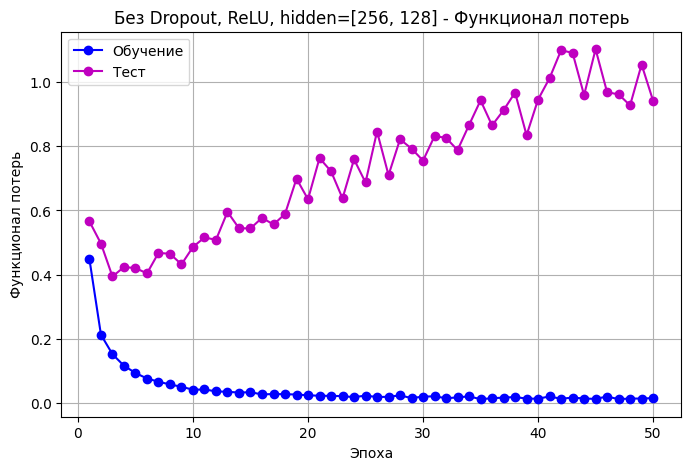

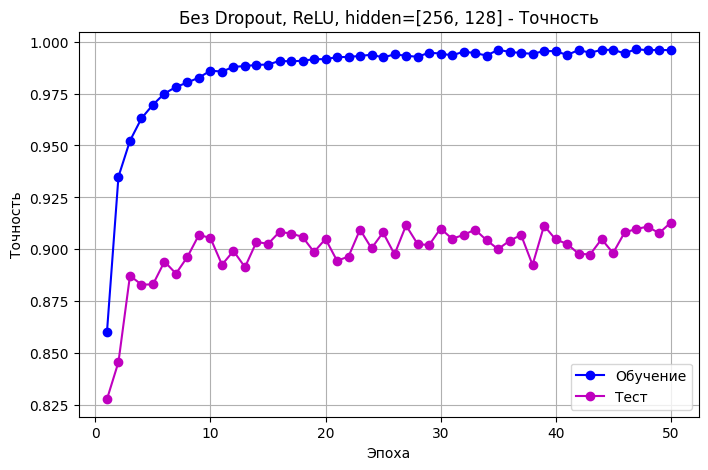

Визуализация ошибок на MNIST:


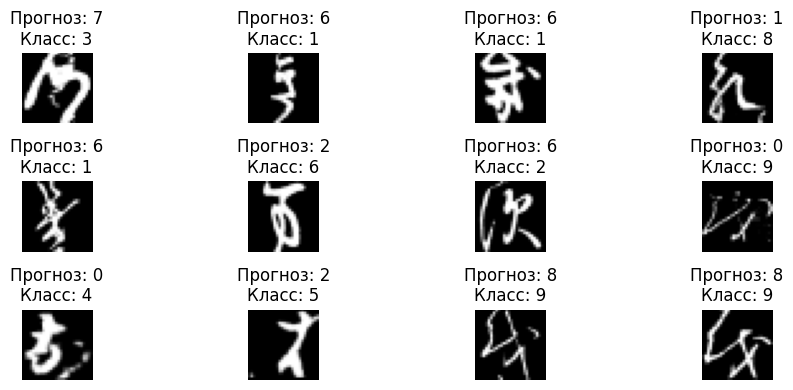

F1-мера для Без Dropout, ReLU, hidden=[256, 128]: 0.9129

--- Эксперимент: С Dropout(0.5), ReLU, hidden=[256, 128] ---
Эпоха 1/50: Train loss=0.7587, Train acc=0.7600 | Test loss=0.7104, Test acc=0.7740
Эпоха 2/50: Train loss=0.4854, Train acc=0.8526 | Test loss=0.5736, Test acc=0.8213
Эпоха 3/50: Train loss=0.4227, Train acc=0.8738 | Test loss=0.5567, Test acc=0.8282
Эпоха 4/50: Train loss=0.3865, Train acc=0.8840 | Test loss=0.5139, Test acc=0.8408
Эпоха 5/50: Train loss=0.3548, Train acc=0.8922 | Test loss=0.4871, Test acc=0.8503
Эпоха 6/50: Train loss=0.3423, Train acc=0.8967 | Test loss=0.4896, Test acc=0.8538
Эпоха 7/50: Train loss=0.3272, Train acc=0.9015 | Test loss=0.4790, Test acc=0.8575
Эпоха 8/50: Train loss=0.3146, Train acc=0.9049 | Test loss=0.4695, Test acc=0.8576
Эпоха 9/50: Train loss=0.3055, Train acc=0.9078 | Test loss=0.4319, Test acc=0.8704
Эпоха 10/50: Train loss=0.2975, Train acc=0.9097 | Test loss=0.4463, Test acc=0.8693
Эпоха 11/50: Train loss=0.2892, Train ac

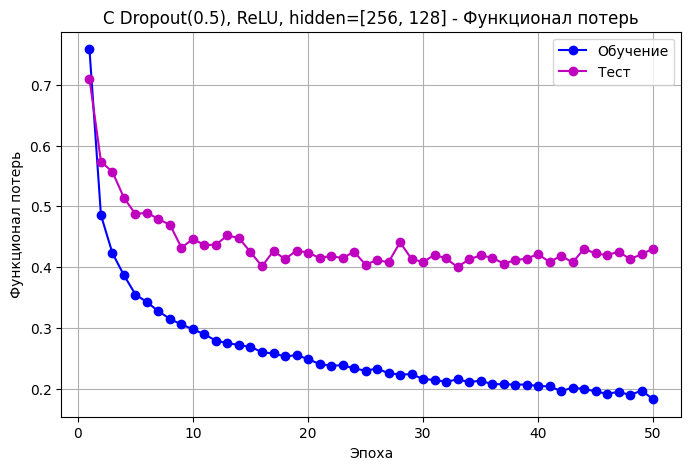

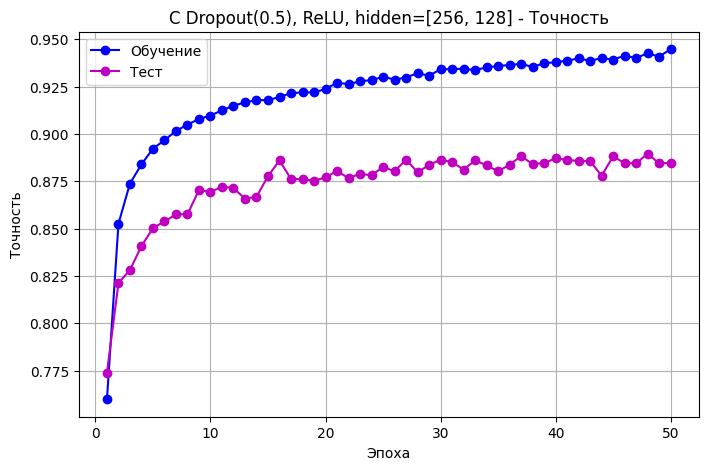

Визуализация ошибок на MNIST:


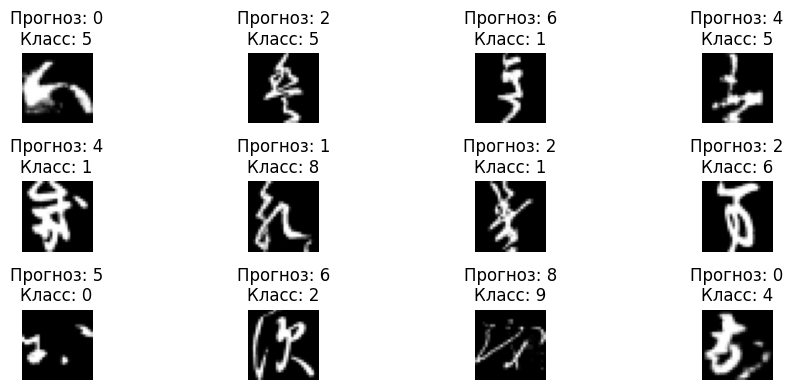

F1-мера для С Dropout(0.5), ReLU, hidden=[256, 128]: 0.8849

--- Эксперимент: Без Dropout, Sigmoid, hidden=[256, 128] ---
Эпоха 1/50: Train loss=0.6990, Train acc=0.7970 | Test loss=0.7275, Test acc=0.7682
Эпоха 2/50: Train loss=0.2953, Train acc=0.9124 | Test loss=0.5422, Test acc=0.8372
Эпоха 3/50: Train loss=0.2029, Train acc=0.9406 | Test loss=0.4452, Test acc=0.8651
Эпоха 4/50: Train loss=0.1527, Train acc=0.9547 | Test loss=0.4374, Test acc=0.8700
Эпоха 5/50: Train loss=0.1179, Train acc=0.9652 | Test loss=0.4352, Test acc=0.8735
Эпоха 6/50: Train loss=0.0934, Train acc=0.9729 | Test loss=0.4226, Test acc=0.8803
Эпоха 7/50: Train loss=0.0764, Train acc=0.9783 | Test loss=0.4556, Test acc=0.8770
Эпоха 8/50: Train loss=0.0629, Train acc=0.9820 | Test loss=0.4400, Test acc=0.8862
Эпоха 9/50: Train loss=0.0524, Train acc=0.9848 | Test loss=0.4639, Test acc=0.8876
Эпоха 10/50: Train loss=0.0429, Train acc=0.9876 | Test loss=0.4624, Test acc=0.8848
Эпоха 11/50: Train loss=0.0383, Train

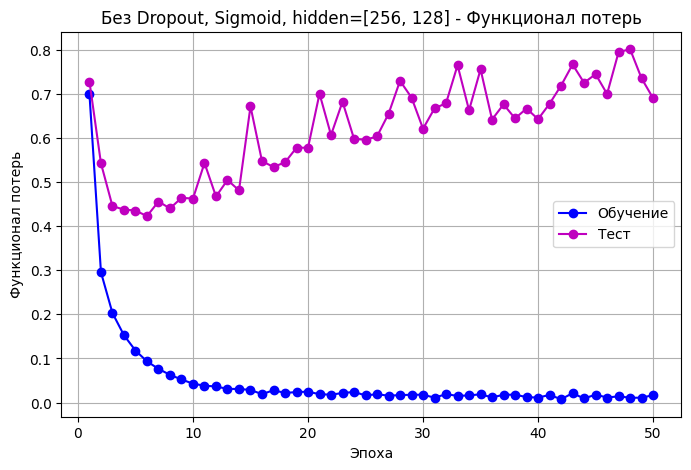

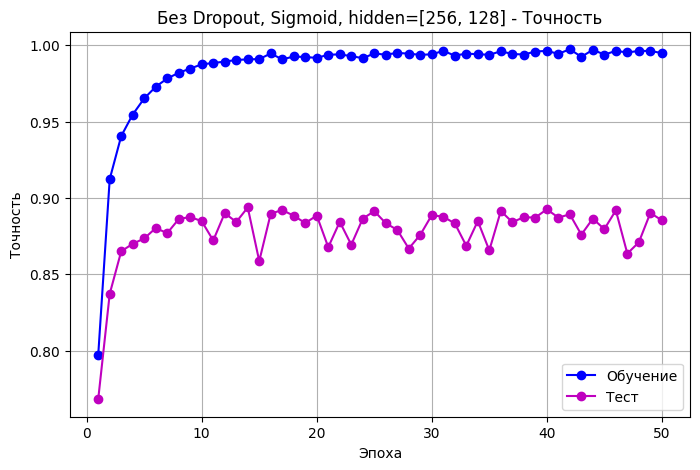

Визуализация ошибок на MNIST:


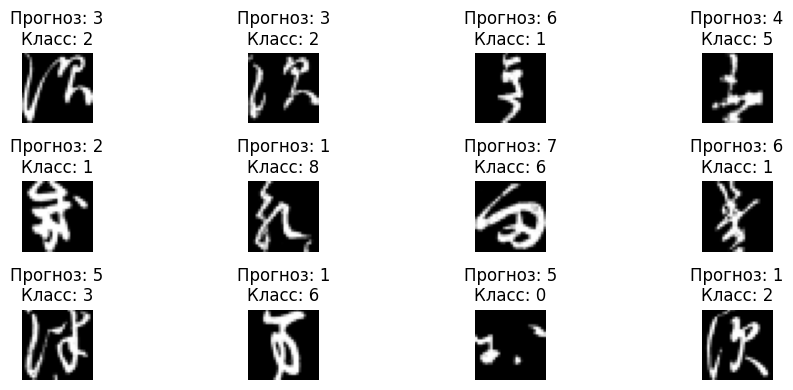

F1-мера для Без Dropout, Sigmoid, hidden=[256, 128]: 0.8852

--- Эксперимент: Без Dropout, Tanh, hidden=[256, 128] ---
Эпоха 1/50: Train loss=0.4688, Train acc=0.8575 | Test loss=0.5922, Test acc=0.8178
Эпоха 2/50: Train loss=0.2334, Train acc=0.9292 | Test loss=0.4992, Test acc=0.8506
Эпоха 3/50: Train loss=0.1740, Train acc=0.9460 | Test loss=0.4602, Test acc=0.8650
Эпоха 4/50: Train loss=0.1448, Train acc=0.9556 | Test loss=0.4835, Test acc=0.8623
Эпоха 5/50: Train loss=0.1197, Train acc=0.9628 | Test loss=0.4205, Test acc=0.8790
Эпоха 6/50: Train loss=0.1063, Train acc=0.9666 | Test loss=0.4979, Test acc=0.8653
Эпоха 7/50: Train loss=0.0912, Train acc=0.9711 | Test loss=0.4898, Test acc=0.8743
Эпоха 8/50: Train loss=0.0891, Train acc=0.9715 | Test loss=0.5150, Test acc=0.8624
Эпоха 9/50: Train loss=0.0793, Train acc=0.9744 | Test loss=0.5013, Test acc=0.8727
Эпоха 10/50: Train loss=0.0753, Train acc=0.9758 | Test loss=0.4904, Test acc=0.8766
Эпоха 11/50: Train loss=0.0679, Train ac

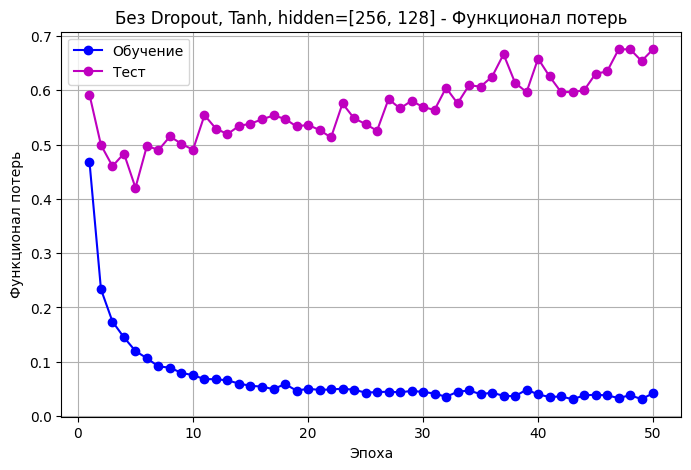

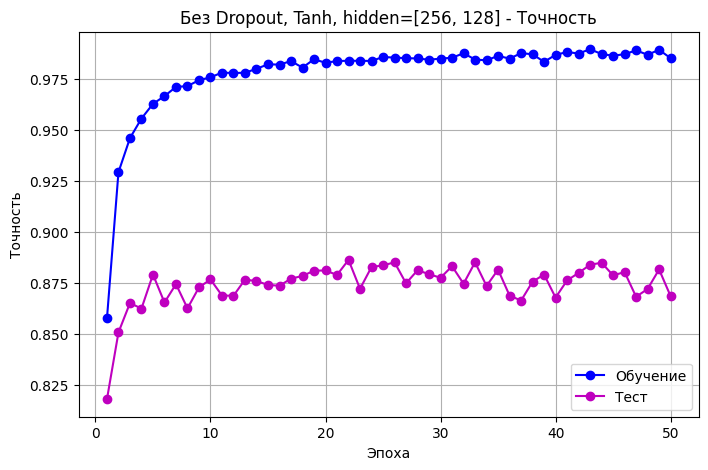

Визуализация ошибок на MNIST:


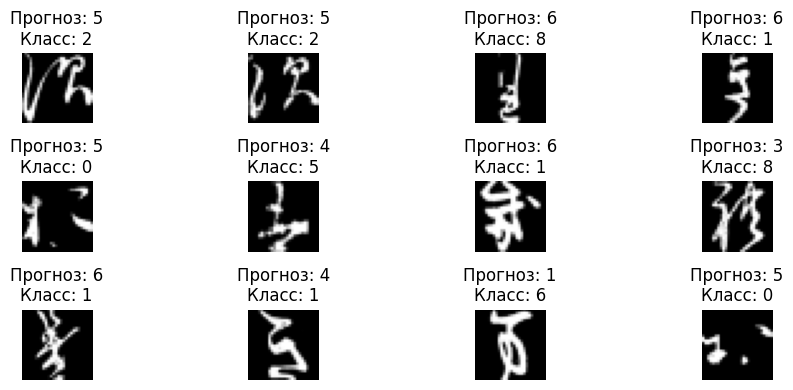

F1-мера для Без Dropout, Tanh, hidden=[256, 128]: 0.8689

--- Эксперимент: Без Dropout, ReLU, hidden=[512, 256] ---
Эпоха 1/50: Train loss=0.4022, Train acc=0.8735 | Test loss=0.5256, Test acc=0.8413
Эпоха 2/50: Train loss=0.1880, Train acc=0.9423 | Test loss=0.4408, Test acc=0.8659
Эпоха 3/50: Train loss=0.1346, Train acc=0.9577 | Test loss=0.4169, Test acc=0.8829
Эпоха 4/50: Train loss=0.0974, Train acc=0.9687 | Test loss=0.4230, Test acc=0.8859
Эпоха 5/50: Train loss=0.0791, Train acc=0.9742 | Test loss=0.4552, Test acc=0.8866
Эпоха 6/50: Train loss=0.0672, Train acc=0.9782 | Test loss=0.4781, Test acc=0.8922
Эпоха 7/50: Train loss=0.0564, Train acc=0.9815 | Test loss=0.4834, Test acc=0.8897
Эпоха 8/50: Train loss=0.0533, Train acc=0.9823 | Test loss=0.4620, Test acc=0.8997
Эпоха 9/50: Train loss=0.0461, Train acc=0.9848 | Test loss=0.4568, Test acc=0.8986
Эпоха 10/50: Train loss=0.0394, Train acc=0.9875 | Test loss=0.4453, Test acc=0.9146
Эпоха 11/50: Train loss=0.0343, Train acc=0

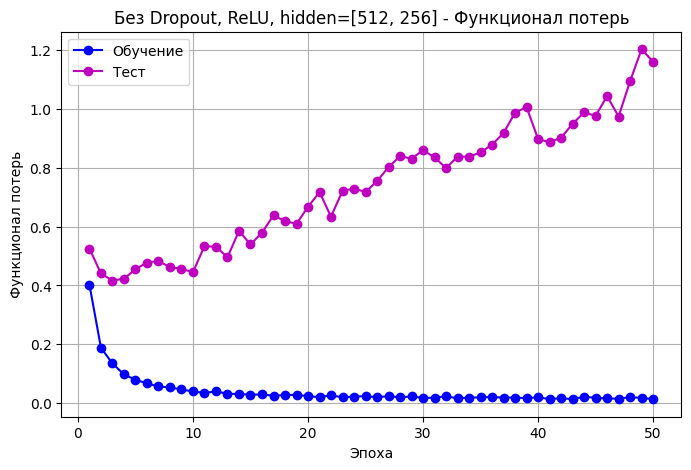

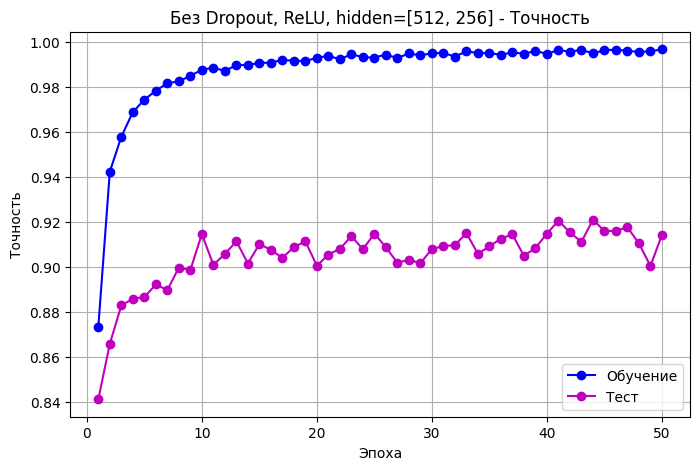

Визуализация ошибок на MNIST:


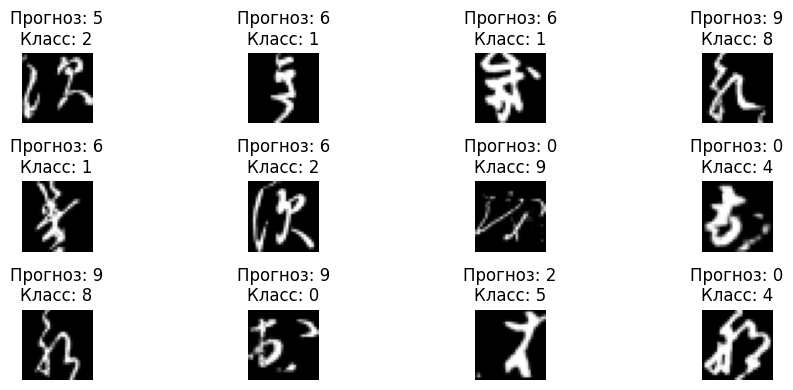

F1-мера для Без Dropout, ReLU, hidden=[512, 256]: 0.9143

--- Эксперимент: Без Dropout, ReLU, hidden=[128, 64] ---
Эпоха 1/50: Train loss=0.5028, Train acc=0.8463 | Test loss=0.5975, Test acc=0.8208
Эпоха 2/50: Train loss=0.2430, Train acc=0.9259 | Test loss=0.5400, Test acc=0.8415
Эпоха 3/50: Train loss=0.1836, Train acc=0.9437 | Test loss=0.5033, Test acc=0.8536
Эпоха 4/50: Train loss=0.1450, Train acc=0.9552 | Test loss=0.4544, Test acc=0.8758
Эпоха 5/50: Train loss=0.1199, Train acc=0.9621 | Test loss=0.4860, Test acc=0.8686
Эпоха 6/50: Train loss=0.1009, Train acc=0.9677 | Test loss=0.4573, Test acc=0.8815
Эпоха 7/50: Train loss=0.0848, Train acc=0.9725 | Test loss=0.4490, Test acc=0.8832
Эпоха 8/50: Train loss=0.0749, Train acc=0.9760 | Test loss=0.4687, Test acc=0.8865
Эпоха 9/50: Train loss=0.0666, Train acc=0.9782 | Test loss=0.5130, Test acc=0.8812
Эпоха 10/50: Train loss=0.0565, Train acc=0.9817 | Test loss=0.4717, Test acc=0.8925
Эпоха 11/50: Train loss=0.0521, Train acc=0.

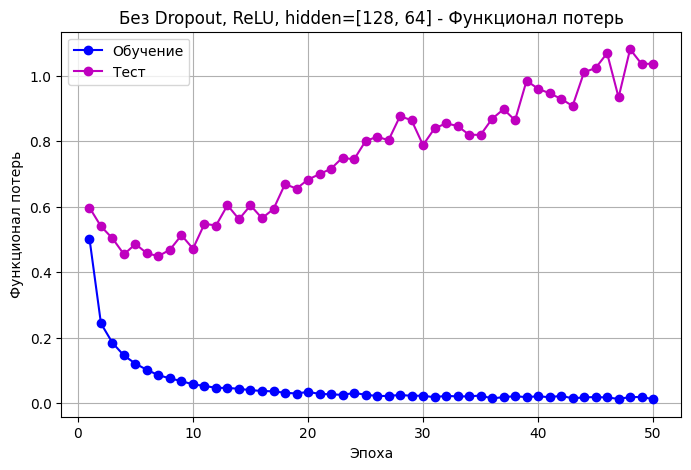

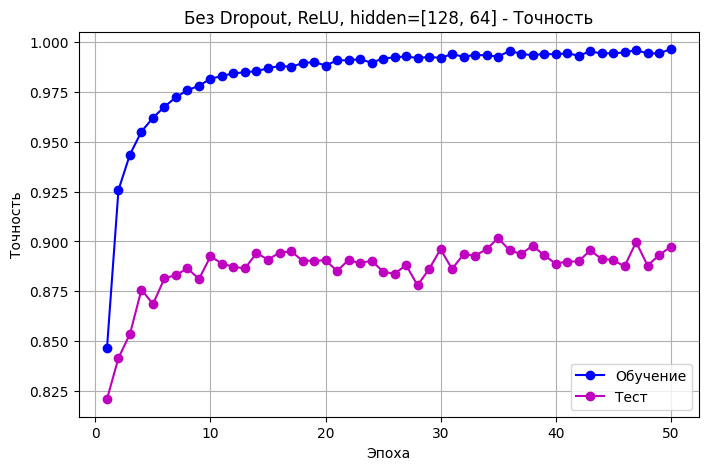

Визуализация ошибок на MNIST:


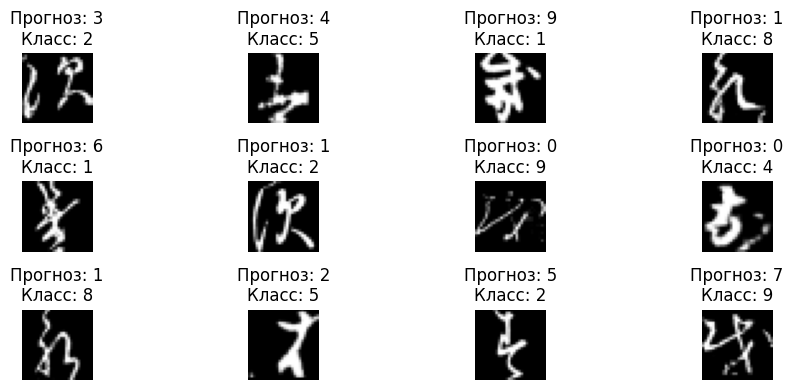

F1-мера для Без Dropout, ReLU, hidden=[128, 64]: 0.8970

--- Эксперимент: Без Dropout, ReLU, hidden=[256, 128, 64] ---
Эпоха 1/50: Train loss=0.4690, Train acc=0.8518 | Test loss=0.5734, Test acc=0.8279
Эпоха 2/50: Train loss=0.2265, Train acc=0.9297 | Test loss=0.5119, Test acc=0.8506
Эпоха 3/50: Train loss=0.1596, Train acc=0.9507 | Test loss=0.4509, Test acc=0.8634
Эпоха 4/50: Train loss=0.1256, Train acc=0.9609 | Test loss=0.4355, Test acc=0.8816
Эпоха 5/50: Train loss=0.1037, Train acc=0.9667 | Test loss=0.4427, Test acc=0.8868
Эпоха 6/50: Train loss=0.0834, Train acc=0.9734 | Test loss=0.4534, Test acc=0.8886
Эпоха 7/50: Train loss=0.0724, Train acc=0.9764 | Test loss=0.4116, Test acc=0.8987
Эпоха 8/50: Train loss=0.0651, Train acc=0.9785 | Test loss=0.4687, Test acc=0.8926
Эпоха 9/50: Train loss=0.0539, Train acc=0.9823 | Test loss=0.4465, Test acc=0.9020
Эпоха 10/50: Train loss=0.0507, Train acc=0.9835 | Test loss=0.4800, Test acc=0.8950
Эпоха 11/50: Train loss=0.0475, Train ac

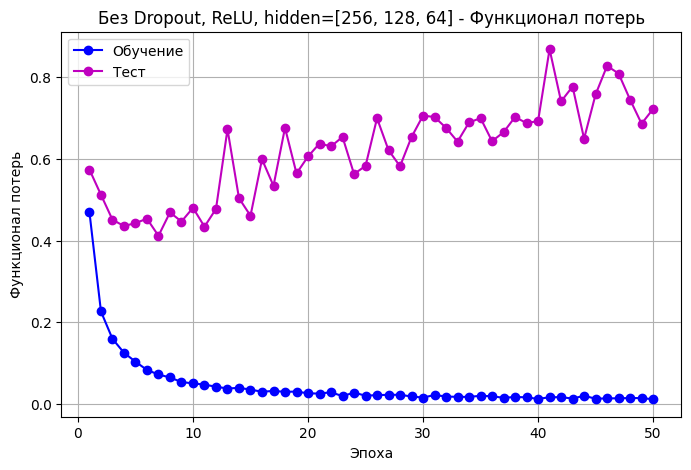

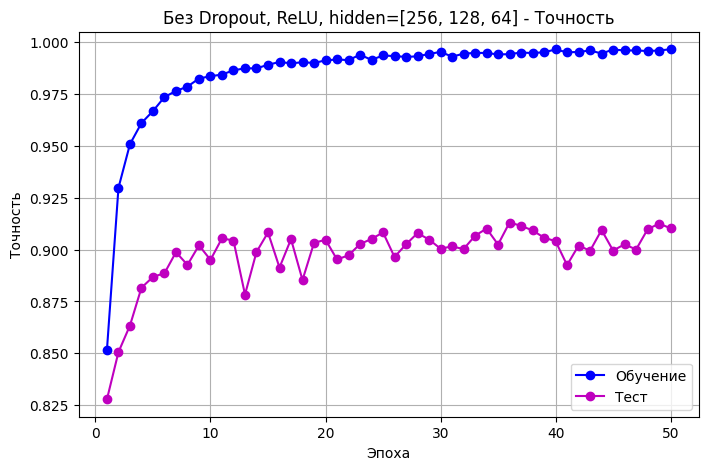

Визуализация ошибок на MNIST:


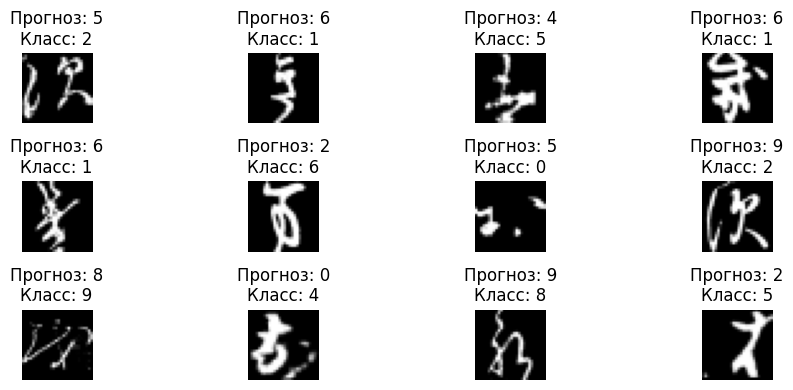

F1-мера для Без Dropout, ReLU, hidden=[256, 128, 64]: 0.9102

--- Эксперимент: Без Dropout, ReLU, hidden=[512, 256, 128] ---
Эпоха 1/50: Train loss=0.4233, Train acc=0.8666 | Test loss=0.5625, Test acc=0.8241
Эпоха 2/50: Train loss=0.1970, Train acc=0.9392 | Test loss=0.5467, Test acc=0.8402
Эпоха 3/50: Train loss=0.1406, Train acc=0.9562 | Test loss=0.3978, Test acc=0.8874
Эпоха 4/50: Train loss=0.1095, Train acc=0.9658 | Test loss=0.4061, Test acc=0.8876
Эпоха 5/50: Train loss=0.0851, Train acc=0.9730 | Test loss=0.4264, Test acc=0.8909
Эпоха 6/50: Train loss=0.0775, Train acc=0.9757 | Test loss=0.4440, Test acc=0.8852
Эпоха 7/50: Train loss=0.0639, Train acc=0.9791 | Test loss=0.3893, Test acc=0.9035
Эпоха 8/50: Train loss=0.0591, Train acc=0.9813 | Test loss=0.4829, Test acc=0.8834
Эпоха 9/50: Train loss=0.0474, Train acc=0.9845 | Test loss=0.4698, Test acc=0.8920
Эпоха 10/50: Train loss=0.0513, Train acc=0.9833 | Test loss=0.4093, Test acc=0.9084
Эпоха 11/50: Train loss=0.0402, Tr

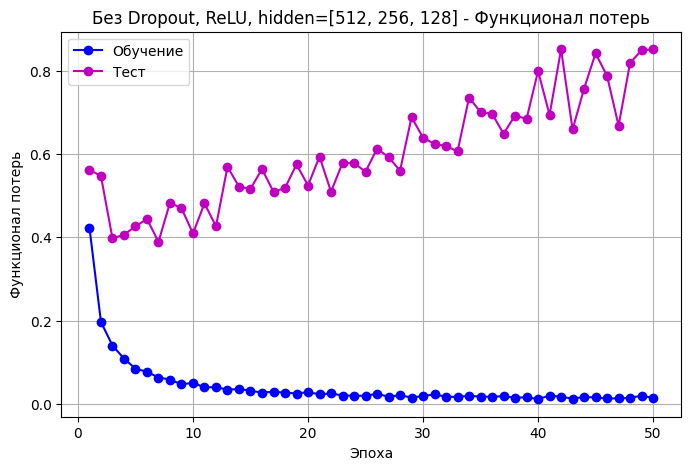

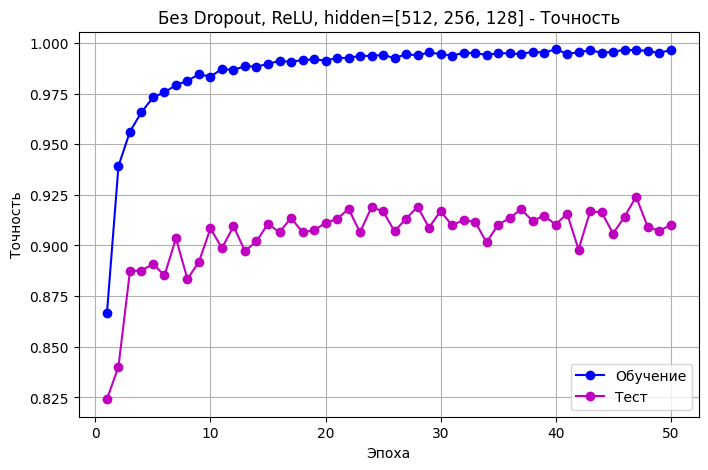

Визуализация ошибок на MNIST:


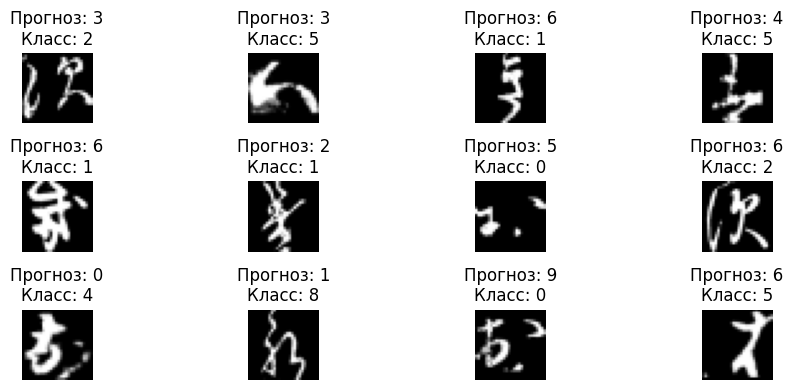

F1-мера для Без Dropout, ReLU, hidden=[512, 256, 128]: 0.9103

--- Эксперимент: С Dropout(0.5), ReLU, hidden=[512, 256, 128] ---
Эпоха 1/50: Train loss=0.7850, Train acc=0.7519 | Test loss=0.7176, Test acc=0.7748
Эпоха 2/50: Train loss=0.4717, Train acc=0.8621 | Test loss=0.6038, Test acc=0.8102
Эпоха 3/50: Train loss=0.4072, Train acc=0.8801 | Test loss=0.5545, Test acc=0.8276
Эпоха 4/50: Train loss=0.3694, Train acc=0.8935 | Test loss=0.5220, Test acc=0.8385
Эпоха 5/50: Train loss=0.3440, Train acc=0.8996 | Test loss=0.5115, Test acc=0.8503
Эпоха 6/50: Train loss=0.3206, Train acc=0.9045 | Test loss=0.4631, Test acc=0.8656
Эпоха 7/50: Train loss=0.3082, Train acc=0.9106 | Test loss=0.4634, Test acc=0.8633
Эпоха 8/50: Train loss=0.2963, Train acc=0.9145 | Test loss=0.4490, Test acc=0.8682
Эпоха 9/50: Train loss=0.2808, Train acc=0.9191 | Test loss=0.4447, Test acc=0.8693
Эпоха 10/50: Train loss=0.2775, Train acc=0.9194 | Test loss=0.4297, Test acc=0.8745
Эпоха 11/50: Train loss=0.2670

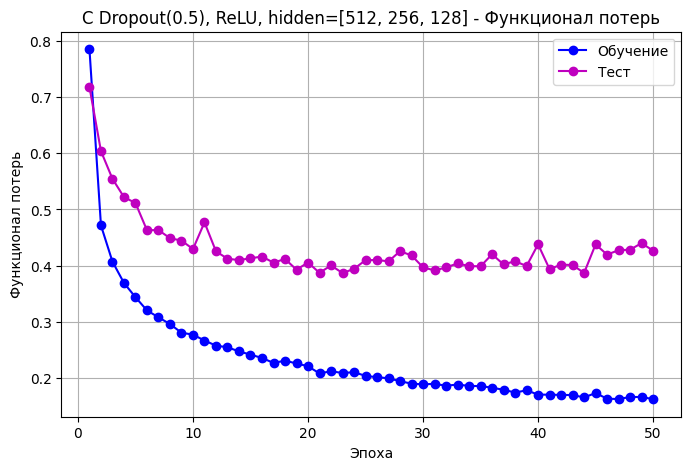

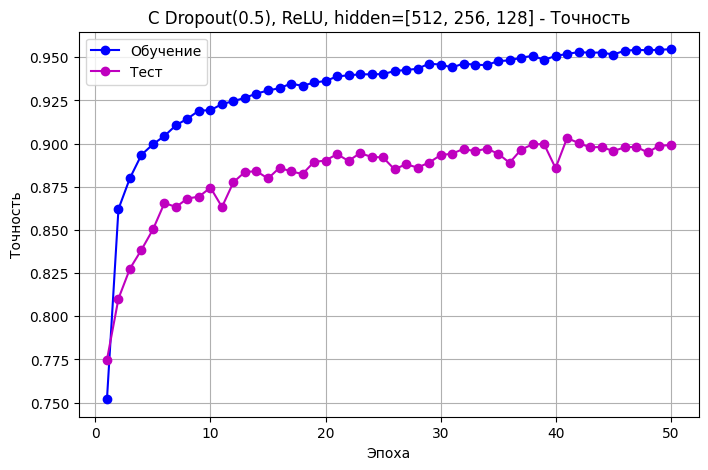

Визуализация ошибок на MNIST:


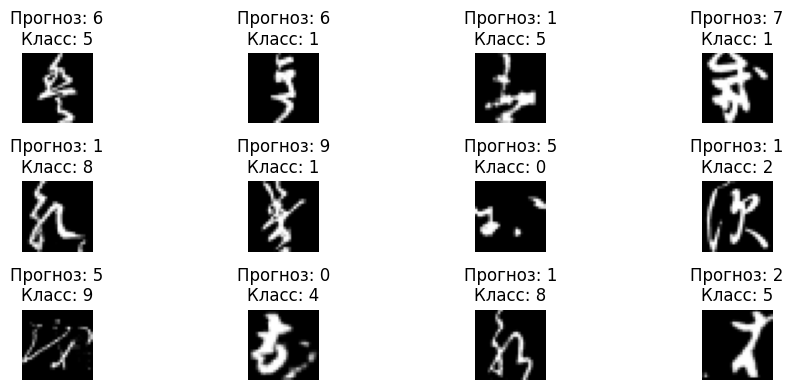

F1-мера для С Dropout(0.5), ReLU, hidden=[512, 256, 128]: 0.8992


In [ ]:
# Словари для хранения метрик по экспериментам
exp_histories = {}

for exp in experiments:
    print(f"\n--- Эксперимент: {exp['name']} ---")
    model = FCNN(input_dim=28*28, hidden_dims=exp["hidden_dims"], output_dim=10,
                  activation=exp["activation"], dropout_prob=exp["dropout"]).to(device)
    criterion_kmnist = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses_exp, train_accuracies_exp = [], []
    test_losses_exp, test_accuracies_exp = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader_kmnist, criterion_kmnist, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader_kmnist, criterion_kmnist, device)
        train_losses_exp.append(train_loss)
        train_accuracies_exp.append(train_acc)
        test_losses_exp.append(test_loss)
        test_accuracies_exp.append(test_acc)
        print(f"Эпоха {epoch+1}/{num_epochs}: Train loss={train_loss:.4f}, Train acc={train_acc:.4f} | Test loss={test_loss:.4f}, Test acc={test_acc:.4f}")

    exp_histories[exp["name"]] = {
        "train_losses": train_losses_exp,
        "train_acc": train_accuracies_exp,
        "test_losses": test_losses_exp,
        "test_acc": test_accuracies_exp,
        "model": model  # сохраняем модель для дальнейшей оценки
    }

    # Построение графиков для текущего эксперимента
    plot_metrics(train_losses_exp, test_losses_exp, ylabel="Функционал потерь", title=f"{exp['name']} - Функционал потерь")
    plot_metrics(train_accuracies_exp, test_accuracies_exp, ylabel="Точность", title=f"{exp['name']} - Точность")

    # Визуализация неверно классифицированных изображений
    print("Визуализация ошибок на MNIST:")
    plot_misclassified(model, test_loader_kmnist, device, num_images=12)

    # Оценка F1-меры на тестовой выборке
    _, _, preds, labels = evaluate(model, test_loader_kmnist, criterion_kmnist, device, return_preds=True)
    f1 = f1_score(labels, preds, average='macro')
    print(f"F1-мера для {exp['name']}: {f1:.4f}")

# Сравнительный анализ

In [ ]:
# Сравнительный анализ – можно вывести сводную таблицу по последней эпохе каждого эксперимента
print("\nСравнительный анализ на KMNIST (последняя эпоха):")
for exp_name, history in exp_histories.items():
    final_train_acc = history["train_acc"][-1]
    final_test_acc = history["test_acc"][-1]
    _, _, preds, labels = evaluate(history["model"], test_loader_kmnist, criterion, device, return_preds=True)
    f1 = f1_score(labels, preds, average='macro')
    print(f"{exp_name}: Train Acc={final_train_acc:.4f}, Test Acc={final_test_acc:.4f}, F1={f1:.4f}")


Сравнительный анализ на KMNIST (последняя эпоха):
Без Dropout, ReLU, hidden=[256, 128]: Train Acc=0.9959, Test Acc=0.9128, F1=0.9129
